# Creating necessary framework

## Create the necessary training data

In [1]:
library(tidyverse)
library(car)
library(olsrr)
library(stringr)
library(tidytext)
library(syuzhet)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
Warning message:
“package ‘tibble’ was built under R version 3.4.4”Warning message:
“package ‘purrr’ was built under R version 3.4.4”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘car’ was built under R version 3.4.4”Loading required package: carData
Warning message:
“package ‘carData’ was built under R version 3.4.4”
Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some


Attaching package: ‘olsrr’

The following object is masked from ‘package:datasets’:

    rivers

Warning message:
“package ‘tidytext’ was built under R version 

In [2]:
# Make sure to change this
setwd("/home/yeachan153/Desktop/BDS/R/Big Data Analytics/Big-Data-Analytics/Text Analytics Project")

" 
Read in the CSV file
"
personality = as.tibble(read.csv("youtube-personality/YouTube-Personality-Personality_impression_scores_train.csv", 
                                 encoding = "UTF-8",
                                 sep = " "))

gender = as.tibble(read.csv("youtube-personality/YouTube-Personality-gender.csv",
                            encoding = "UTF-8",
                            sep = " "))

audiovisual = as.tibble(read.csv("youtube-personality/YouTube-Personality-audiovisual_features.csv",
                                 encoding = "UTF-8",
                                 sep = " "))

transcripts = as.tibble(read.csv("youtube-personality/transcripts.csv",
                                 encoding = "UTF-8",
                                 sep = ","))
transcripts$index = as.character(transcripts$index)

transcripts =
  transcripts %>%
  rename(vlogId = index,
         transcript = X0) %>%
  mutate(vlogId = substr(vlogId, 1, nchar(vlogId)-4))

personality$vlogId = as.character(personality$vlogId)
gender$vlogId = as.character(gender$vlogId)
audiovisual$vlogId = as.character(audiovisual$vlogId)

training_data = 
  personality %>%
  left_join(gender, on = c("vlogID" = "vlogID")) %>%
  left_join(audiovisual, on = c("vlogID" = "vlogID")) %>%
  left_join(transcripts, on = c("clogID" = "vlogID"))

#tokenization
training_data$transcript <- as.vector(training_data$transcript)
tidy_data <- training_data %>% 
  unnest_tokens(word, transcript, to_lower = TRUE) %>% 
  anti_join(get_stopwords())

#count the total number of words for each person
total_words <- tidy_data %>% 
  group_by(vlogId) %>% 
  count() %>% 
  rename(total_words = n)

#count the percentage of words related to big 5
words_E = c("bar","drinks", "restaurant", "dancing", "restaurants", "grandfather", "miami", "countless", "drinking", "shots", "girls", "glorious", "pool", "crowd", "sang", "grilled")
words_A = c("wonderful", "together", "visiting", "morning", "spring", "walked", "beautiful", "staying", "felt", "share", "gray", "joy", "afternoon", "day", "moments", "hug", "glad")
words_C = c("completed", "adventure", "adventures", "enjoying", "hawaii", "it's", "deck")
words_N = c("awful", "though", "lazy", "worse", "depressing", "irony", "terrible", "stressful", "horrible", "sort", "annoying", "ashamed", "ban")
words_O = c("folk", "humans", "of", "poet", "art", "by", "universe", "poetry", "narrative", "culture", "century", "sexual", "films", "novel", "decades", "ink", "passage", "literature", "blues")
words_nE = c("other", "cats", "computer", "minor")
words_nA = c("porn", "cost", "fuck")
words_nC = c("stupid", "boring", "desperate", "saying", "utter", "it's", "extreme")
words_nN = c("road", "southern", "visited", "ground", "oldest", "invited", "completed")
words_nO = c("giveaway")

check_words <- function(wordlist){
  tidy_data %>% 
    filter(word %in% wordlist) %>% 
    group_by(vlogId) %>% 
    count() %>% 
    left_join(total_words) %>% 
    mutate(n/total_words) %>% 
    select(-n, -total_words)
}

E_words <- check_words(words_E) %>% 
  rename(words_Extraversion = 'n/total_words')

A_words <- check_words(words_A) %>% 
  rename(words_Agreeableness = 'n/total_words')

C_words <- check_words(words_C) %>% 
  rename(words_Conscientiousness = 'n/total_words')

N_words <- check_words(words_N) %>% 
  rename(words_Neuroticism = 'n/total_words')

O_words <- check_words(words_O) %>% 
  rename(words_Openness = 'n/total_words')

nE_words <- check_words(words_nE) %>% 
  rename(words_nExtraversion = 'n/total_words')

nA_words <- check_words(words_nA) %>% 
  rename(words_nAgreeableness = 'n/total_words')

nC_words <- check_words(words_nC) %>% 
  rename(words_nConscientiousness = 'n/total_words')

nN_words <- check_words(words_nN) %>% 
  rename(words_nNeuroticism = 'n/total_words')

nO_words <- check_words(words_nO) %>% 
  rename(words_nOpenness = 'n/total_words')

#putting them back to the training data
training_data <- training_data %>% 
  left_join(E_words) %>%
  left_join(A_words) %>%
  left_join(C_words) %>%
  left_join(N_words) %>%
  left_join(O_words) %>%
  left_join(nE_words) %>%
  left_join(nA_words) %>%
  left_join(nC_words) %>%
  left_join(nN_words) %>%
  left_join(nO_words) %>% 
  replace(., is.na(.), 0)

#sentiment analysis with nrc
nrc <- tidy_data %>% 
  inner_join(get_sentiments('nrc')) %>%
  count(`vlogId`, sentiment) %>%
  spread(sentiment, n, fill = 0)

training_data <- training_data %>% 
  left_join(nrc) %>%
  left_join(total_words) %>%
  mutate(anger = anger / total_words,
         anticipation = anticipation / total_words,
         disgust = disgust / total_words,
         fear = fear / total_words,
         joy = joy / total_words,
         negative = negative / total_words,
         positive = positive / total_words,
         sadness = sadness / total_words,
         surprise = surprise / total_words,
         trust = trust / total_words) %>%
  select(-total_words, -transcript)

#sentiment analysis with afinn
afinn = tidy_data %>% 
  inner_join(get_sentiments('afinn')) %>% 
  group_by(vlogId) %>% 
  summarise(sentiment = sum(score))

training_data <- training_data %>% 
  left_join(afinn) 

temp1 = 
  training_data %>%
  select(-vlogId, - gender,
         - Extr:-Open) %>%
  scale()

training_data = 
  training_data %>%
  select(vlogId, gender,
         Extr:Open) %>%
  cbind(temp1)

[1] " \nRead in the CSV file\n"

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "word"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "word"
Joining, by = "vlogId"
Joining, by = "vlogId"
Joining, by = "word"
Joining, by = "vlogId"


## Baseline

In [3]:
training_data = training_data[c(2,5,8:53)]
baseline <- lm(Cons ~ ., data= training_data)
summary(baseline) #adj R^2 =  0.1702 


Call:
lm(formula = Cons ~ ., data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.07216 -0.41725  0.05849  0.43109  1.75268 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.4924807  0.0744540  60.339  < 2e-16 ***
genderMale                0.0400153  0.1279916   0.313  0.75479    
mean.pitch               -0.0944209  0.0792203  -1.192  0.23433    
sd.pitch                 -0.0974586  0.0796624  -1.223  0.22222    
mean.conf.pitch          -0.0846282  0.1361994  -0.621  0.53488    
sd.conf.pitch             0.0342462  0.0860154   0.398  0.69083    
mean.spec.entropy        -0.3682702  0.1283596  -2.869  0.00444 ** 
sd.spec.entropy          -0.1085123  0.0781236  -1.389  0.16596    
mean.val.apeak            0.0170062  0.0949883   0.179  0.85804    
sd.val.apeak              0.1500288  0.0751725   1.996  0.04694 *  
mean.loc.apeak            0.0688339  0.1071986   0.642  0.52133    
sd.loc.apeak 

Warning message:
“not plotting observations with leverage one:
  28”Warning message:
“not plotting observations with leverage one:
  28”

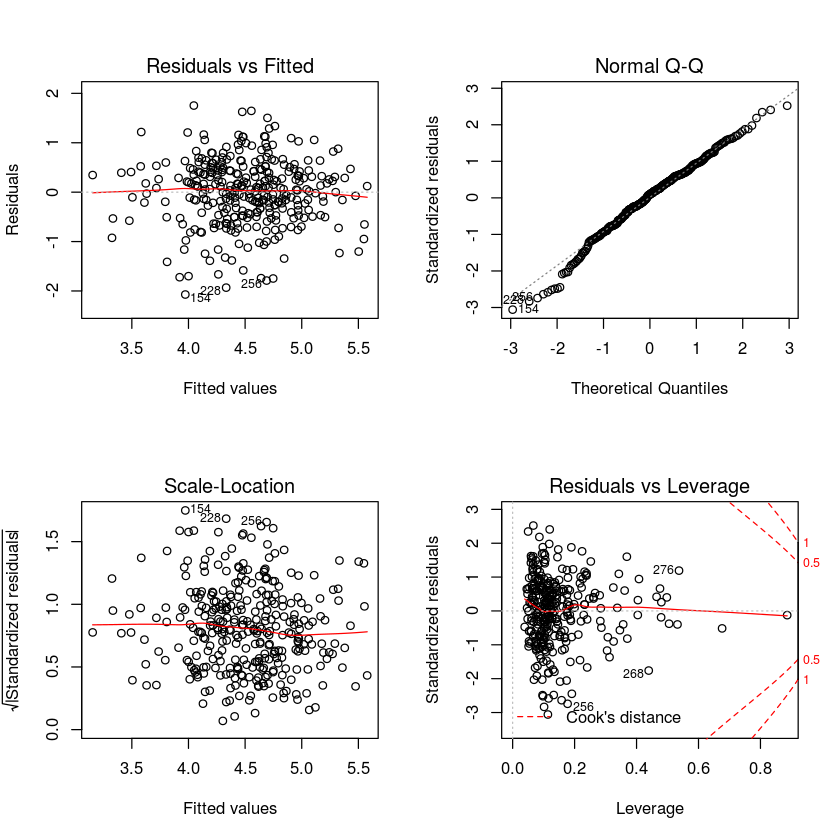

In [4]:
par(mfrow = c(2,2))
plot(baseline)

## Model 2 - remove multicollinear features

In [5]:
VIF <- vif(baseline)
VIF[VIF > 10] 

# Removing multicolinearity:
model2 <-  update(baseline, ~.
                  -mean.num.apeak
                  -avg.voiced.seg)
summary(model2) # adjusted r squared:  0.163

mean.conf.pitch mean.spec.entropy    mean.num.apeak    avg.voiced.seg 
         11.57107          10.27732          11.89223          11.62388


Call:
lm(formula = Cons ~ gender + mean.pitch + sd.pitch + mean.conf.pitch + 
    sd.conf.pitch + mean.spec.entropy + sd.spec.entropy + mean.val.apeak + 
    sd.val.apeak + mean.loc.apeak + sd.loc.apeak + sd.num.apeak + 
    mean.energy + sd.energy + mean.d.energy + sd.d.energy + avg.len.seg + 
    time.speaking + voice.rate + num.turns + hogv.entropy + hogv.median + 
    hogv.cogR + hogv.cogC + words_Extraversion + words_Agreeableness + 
    words_Conscientiousness + words_Neuroticism + words_Openness + 
    words_nExtraversion + words_nAgreeableness + words_nConscientiousness + 
    words_nNeuroticism + words_nOpenness + anger + anticipation + 
    disgust + fear + joy + negative + positive + sadness + surprise + 
    trust + sentiment, data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.04744 -0.44519  0.07289  0.45155  1.69522 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.487935   0.074

## Model 3 - Backward selection

In [6]:
remove <- ols_step_backward(model2)
paste(remove$removed, collapse = " - ")
model3 <- update(model2, ~.
                 - hogv.cogR - negative - num.turns - words_nConscientiousness 
                 - sd.num.apeak - sd.loc.apeak - words_Conscientiousness - gender 
                 - sd.conf.pitch - mean.conf.pitch - mean.energy - words_nAgreeableness 
                 - sadness - voice.rate - hogv.median - sentiment - sd.spec.entropy 
                 - mean.val.apeak - words_nExtraversion - trust - words_Agreeableness)
summary(model3) # Adjusted R-squared:  0.2072 

We are eliminating variables based on p value...
No more variables satisfy the condition of prem: 0.3


[1] "hogv.cogR - negative - num.turns - words_nConscientiousness - sd.num.apeak - sd.loc.apeak - words_Conscientiousness - gender - sd.conf.pitch - mean.conf.pitch - mean.energy - words_nAgreeableness - sadness - voice.rate - hogv.median - sentiment - sd.spec.entropy - mean.val.apeak - words_nExtraversion - trust - words_Agreeableness"


Call:
lm(formula = Cons ~ mean.pitch + sd.pitch + mean.spec.entropy + 
    sd.val.apeak + mean.loc.apeak + sd.energy + mean.d.energy + 
    sd.d.energy + avg.len.seg + time.speaking + hogv.entropy + 
    hogv.cogC + words_Extraversion + words_Neuroticism + words_Openness + 
    words_nNeuroticism + words_nOpenness + anger + anticipation + 
    disgust + fear + joy + positive + surprise, data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.00844 -0.39149  0.06291  0.42441  1.71648 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         4.51212    0.03907 115.475  < 2e-16 ***
mean.pitch         -0.11567    0.05292  -2.186  0.02960 *  
sd.pitch           -0.09656    0.05494  -1.757  0.07988 .  
mean.spec.entropy  -0.11240    0.05630  -1.996  0.04679 *  
sd.val.apeak        0.11125    0.04752   2.341  0.01988 *  
mean.loc.apeak      0.07392    0.05217   1.417  0.15755    
sd.energy          -0.05070    0.04552  -1.114  

## Model 4 - Remove outliers

In [7]:
outlierTest(model3) 
training_data <- training_data[-228,]
model4 <- update(model2, ~.
                 - hogv.cogR - negative - num.turns - words_nConscientiousness 
                 - sd.num.apeak - sd.loc.apeak - words_Conscientiousness - gender 
                 - sd.conf.pitch - mean.conf.pitch - mean.energy - words_nAgreeableness 
                 - sadness - voice.rate - hogv.median - sentiment - sd.spec.entropy 
                 - mean.val.apeak - words_nExtraversion - trust - words_Agreeableness)
summary(model4) # Adjusted R-squared:  0.212 

No Studentized residuals with Bonferonni p < 0.05
Largest |rstudent|:
     rstudent unadjusted p-value Bonferonni p
228 -2.944381          0.0034908           NA


Call:
lm(formula = Cons ~ mean.pitch + sd.pitch + mean.spec.entropy + 
    sd.val.apeak + mean.loc.apeak + sd.energy + mean.d.energy + 
    sd.d.energy + avg.len.seg + time.speaking + hogv.entropy + 
    hogv.cogC + words_Extraversion + words_Neuroticism + words_Openness + 
    words_nNeuroticism + words_nOpenness + anger + anticipation + 
    disgust + fear + joy + positive + surprise, data = training_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8784 -0.3987  0.0762  0.4021  1.7173 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         4.51854    0.03864 116.926  < 2e-16 ***
mean.pitch         -0.11252    0.05227  -2.153   0.0321 *  
sd.pitch           -0.09887    0.05426  -1.822   0.0694 .  
mean.spec.entropy  -0.11261    0.05559  -2.026   0.0437 *  
sd.val.apeak        0.10504    0.04697   2.237   0.0261 *  
mean.loc.apeak      0.07876    0.05154   1.528   0.1275    
sd.energy          -0.05027    0.04494  -1.119   0.2642   

## Model 5 - Non linear relationships

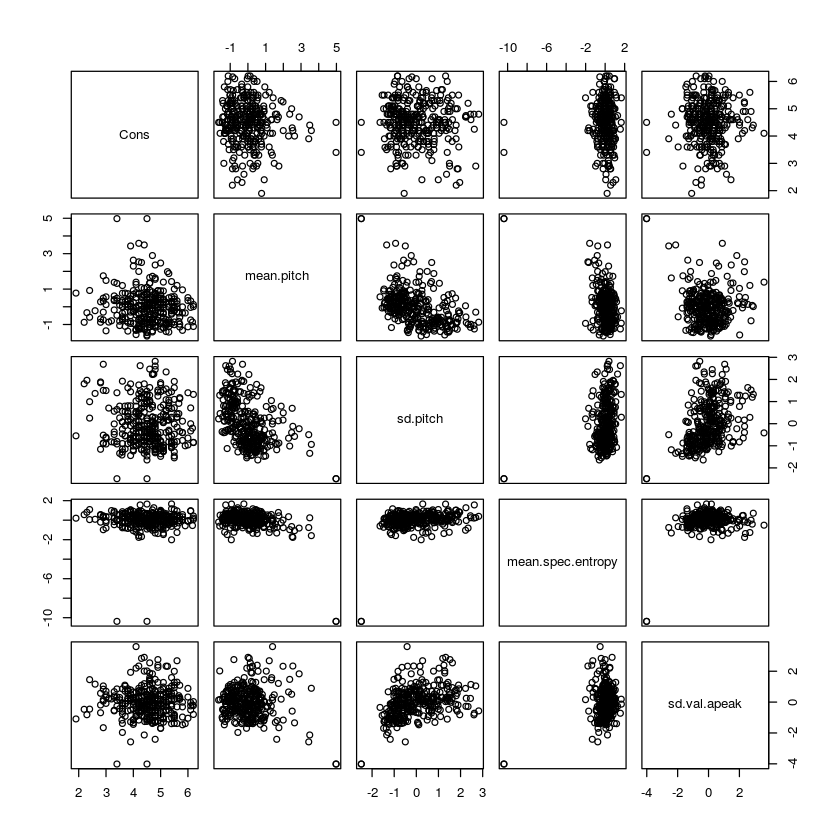

In [8]:
# Nonlinear relationships:
training_data <- 
    training_data %>%
    select(Cons, mean.pitch, sd.pitch, mean.spec.entropy,
           sd.val.apeak, mean.loc.apeak, sd.energy,  mean.d.energy,
           sd.d.energy, avg.len.seg, time.speaking, hogv.entropy,
           hogv.cogC, words_Extraversion, words_Neuroticism, words_Openness,
           words_nNeuroticism, words_nOpenness, anger, anticipation,
           disgust, fear, joy, positive, surprise)
pairs(training_data[,c(1:5)])

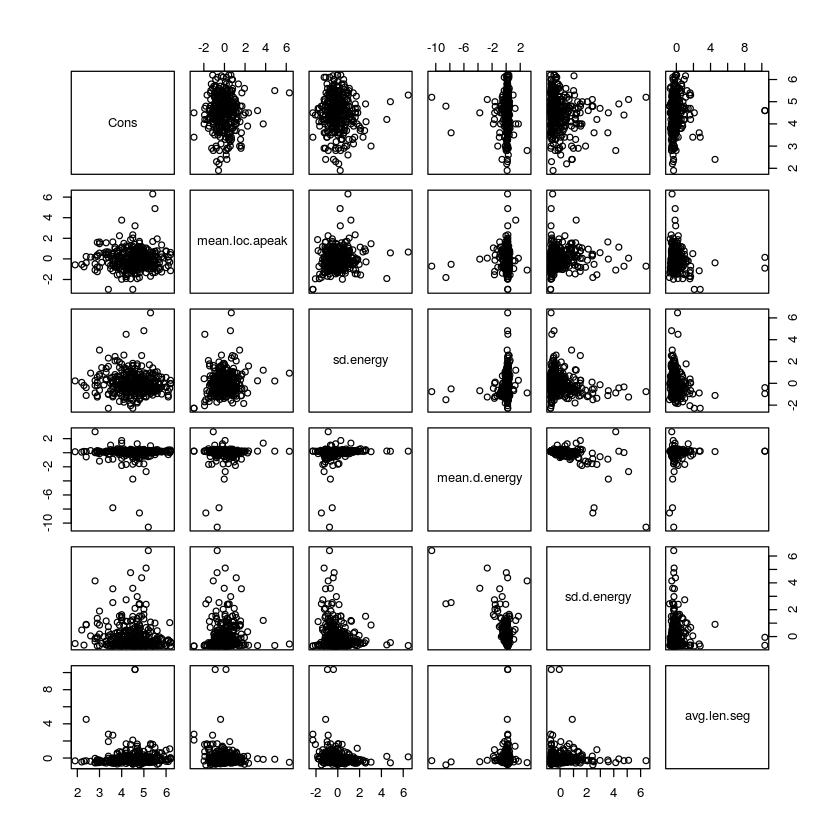

In [9]:
pairs(training_data[,c(1,6:10)])

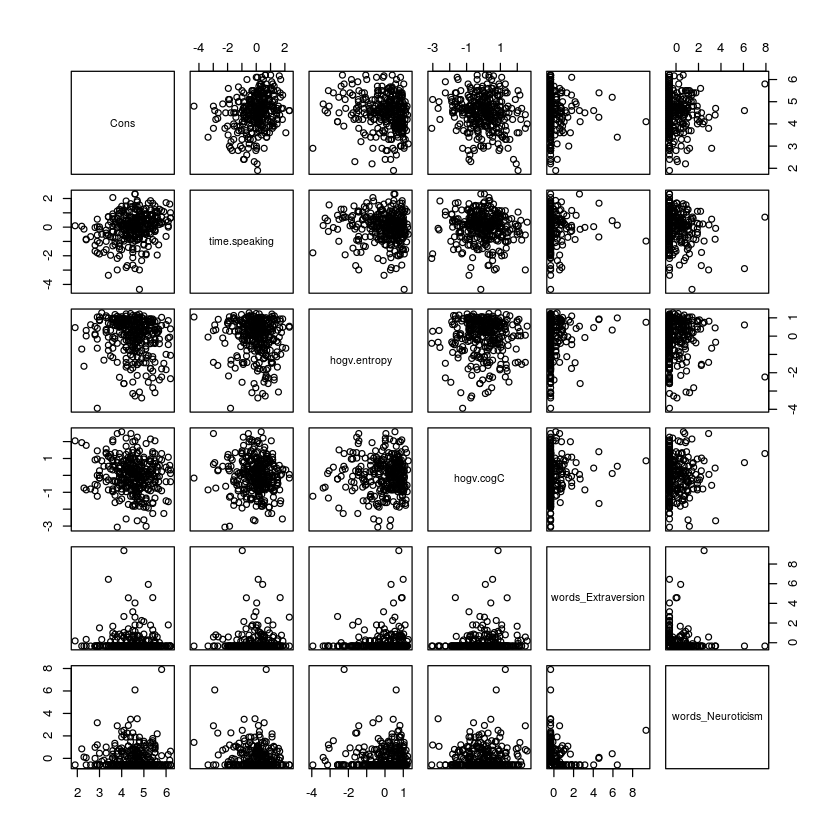

In [10]:
pairs(training_data[,c(1,11:15)])

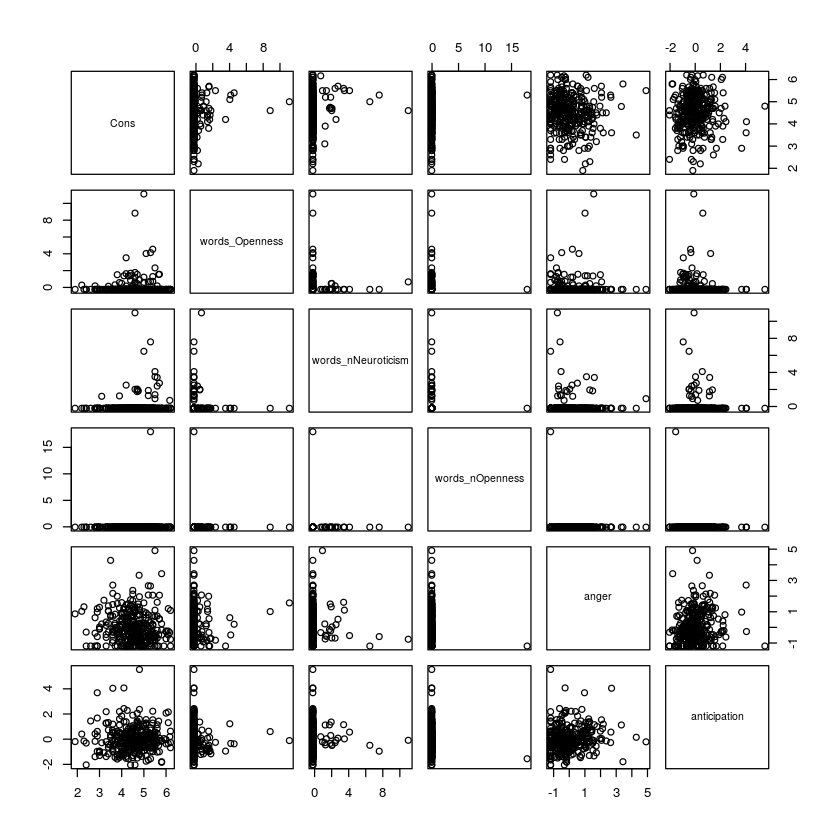

In [11]:
pairs(training_data[,c(1,16:20)])

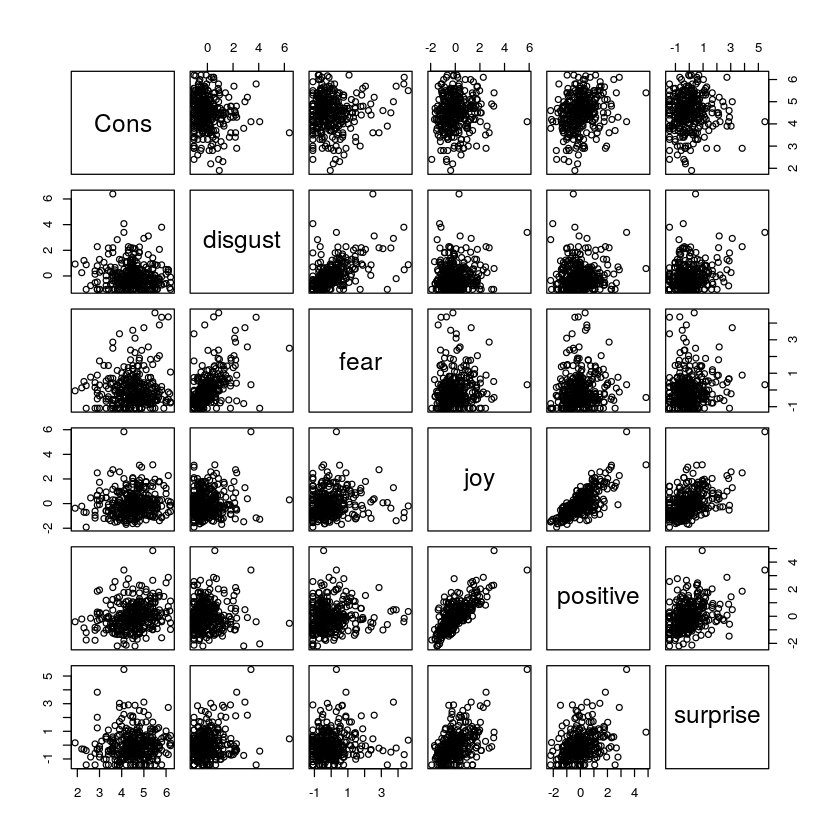

In [12]:
pairs(training_data[,c(1,21:25)])

In [13]:
model5 = update(model4, ~. + I(sd.d.energy**2))
summary(model5) # adj r^2 = .22


Call:
lm(formula = Cons ~ mean.pitch + sd.pitch + mean.spec.entropy + 
    sd.val.apeak + mean.loc.apeak + sd.energy + mean.d.energy + 
    sd.d.energy + avg.len.seg + time.speaking + hogv.entropy + 
    hogv.cogC + words_Extraversion + words_Neuroticism + words_Openness + 
    words_nNeuroticism + words_nOpenness + anger + anticipation + 
    disgust + fear + joy + positive + surprise + I(sd.d.energy^2), 
    data = training_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.90704 -0.40963  0.05222  0.41181  1.72755 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         4.47570    0.04336 103.211  < 2e-16 ***
mean.pitch         -0.12093    0.05211  -2.321  0.02097 *  
sd.pitch           -0.11109    0.05424  -2.048  0.04144 *  
mean.spec.entropy  -0.10965    0.05528  -1.983  0.04824 *  
sd.val.apeak        0.11431    0.04689   2.438  0.01536 *  
mean.loc.apeak      0.08432    0.05130   1.643  0.10134    
sd.energy          -0.05